##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 線形混合効果モデル

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Models"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Linear_Mixed_Effects_Models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Linear_Mixed_Effects_Models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Linear_Mixed_Effects_Models.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

線形混合効果モデルは、構造化された線形関係をモデル化するための単純なアプローチです (Harville, 1997; Laird and Ware, 1982)。各データポイントは、グループに分類されたさまざまな型の入力と実数値の出力で構成されます。線形混合効果モデルは*階層モデル*であり、個々のデータポイントに関する推論を改善するために、グループ間で統計的強度を共有します。

このチュートリアルでは、TensorFlow Probability の実際の例を使用して線形混合効果モデルを示します。JointDistributionCoroutine モジュールとマルコフ連鎖モンテカルロ法 (`tfp.mcmc`) のモジュールを使用します。

### 依存関係と前提条件


In [ ]:
#@title Import and set ups{ display-mode: "form" }


import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')

### 迅速に作成

はじめる前に、このデモに GPU を使用していることを確認します。

[ランタイム] -&gt; [ランタイムタイプの変更] -&gt; [ハードウェアアクセラレータ] -&gt; [GPU] を選択します。

次のスニペットは、GPU にアクセスできることを確認します。

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

注意: 何らかの理由で GPU にアクセスできない場合でも、このコラボは機能します (トレーニングには時間がかかります)。

## データ

人気のある [R の `lme4` パッケージ](https://CRAN.R-project.org/package=lme4) の `InstEval` データセットを使用します (Bates et al., 2015)。これはコースとその授業評価のデータセットです。各コースには、`students`、`instructors`、および `departments` などのメタデータが含まれており、対象の応答変数は授業評価です。

In [ ]:
def load_insteval():
  """Loads the InstEval data set.

  It contains 73,421 university lecture evaluations by students at ETH
  Zurich with a total of 2,972 students, 2,160 professors and
  lecturers, and several student, lecture, and lecturer attributes.
  Implementation is built from the `observations` Python package.

  Returns:
    Tuple of np.ndarray `x_train` with 73,421 rows and 7 columns and
    dictionary `metadata` of column headers (feature names).
  """
  url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/'
         'lme4/InstEval.csv')
  with requests.Session() as s:
    download = s.get(url)
    f = download.content.decode().splitlines()

  iterator = csv.reader(f)
  columns = next(iterator)[1:]
  x_train = np.array([row[1:] for row in iterator], dtype=np.int)
  metadata = {'columns': columns}
  return x_train, metadata

データセットを読み込んで前処理します。データの 20％ を保持しているため、非表示のデータポイントで近似モデルを評価できます。以下では、最初の数行を視覚化します。

In [ ]:
data, metadata = load_insteval()
data = pd.DataFrame(data, columns=metadata['columns'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})
data['students'] -= 1  # start index by 0
# Remap categories to start from 0 and end at max(category).
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

<ipython-input-4-5d7a9eabeea1>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = np.array([row[1:] for row in iterator], dtype=np.int)


students  instructors  studage  lectage  service  departments  ratings
60982      2471            8        6        1        0            1        2
12205       469         1093        6        2        0            1        1
34728      1409          612        8        3        0            3        3
42492      1726          361        2        1        0           11        3
48252      1944          640        2        1        0            8        4

入力の `features` ディクショナリと評価に対応する `labels` 出力の観点からデータセットを設定します。各特徴は整数としてエンコードされ、各ラベル (評価) は浮動小数点数としてエンコードされます。

In [ ]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {
    k: get_value(train, key=k, dtype=np.int32)
    for k in ['students', 'instructors', 'departments', 'service']}
labels_train = get_value(train, key='ratings', dtype=np.float32)

features_test = {k: get_value(test, key=k, dtype=np.int32)
                 for k in ['students', 'instructors', 'departments', 'service']}
labels_test = get_value(test, key='ratings', dtype=np.float32)

In [ ]:
num_students = max(features_train['students']) + 1
num_instructors = max(features_train['instructors']) + 1
num_departments = max(features_train['departments']) + 1
num_observations = train.shape[0]

print("Number of students:", num_students)
print("Number of instructors:", num_instructors)
print("Number of departments:", num_departments)
print("Number of observations:", num_observations)

Number of students: 2972
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


## モデル

典型的な線形モデルは、データポイントの任意のペアが一定の線形関係を持つ独立性を前提としています。`InstEval` データセットでは、観測値はグループで発生し、各グループの勾配と切片は多様です。階層線形モデルまたはマルチレベル線形モデルとも呼ばれる線形混合効果モデルは、この現象を捉えます (Gelman &amp; Hill, 2006)。

この現象の例は次のとおりです。

- **学生**。学生からの観察は独立していません。一部の学生は、体系的に低い (または高い) 授業評価を与える場合があります。
- **講師**。講師からの観察は独立していません。優秀な講師は一般的に高い授業評価を持ち、優秀ではない講師は一般的に低い授業評価を持っていることが期待されます。
- **学部**。学部からの観察は独立していません。特定の学部は、授業が難しかったり、成績評価が厳格なため、他の学部よりも授業評価が低くなる場合があります。

これをキャプチャするために、$N\times D$ 特徴 $\mathbf{X}$ と $N$ ラベル $\mathbf{y}$ のデータセットの場合、線形回帰が以下のモデルを仮定することを忘れないでください。

$$
\begin{equation*}
\mathbf{y} = \mathbf{X}\beta + \alpha + \epsilon,
\end{equation*}
$$

ここで、勾配ベクトルは $\beta\in\mathbb{R}^D$、切片は $ $\alpha\in\mathbb{R}$、およびランダムノイズは$\epsilon\sim\text{Normal}(\mathbf{0}, \mathbf{I})$ です。<br>$\beta$ and $\alpha$ は「固定効果」です。これらは、データポイント $(x, y)$ の母集団全体で一定に保たれる効果です。尤度の方程式の同等の定式化は、$\mathbf{y} \sim \text{Normal}(\mathbf{X}\beta + \alpha, \mathbf{I})$ です。この尤度は、データに適合する $\beta$ and $\alpha$ の点推定を見つけるために、推論中に最大化されます。

線形混合効果モデルは、線形回帰を次のように拡張します。

$$
\begin{align*}
\eta &amp;\sim \text{Normal}(\mathbf{0}, \sigma^2 \mathbf{I}), \\
\mathbf{y} &amp;= \mathbf{X}\beta + \mathbf{Z}\eta + \alpha + \epsilon.
\end{align*}
$$

ここでは、勾配ベクトルは $\beta\in\mathbb{R}^P$、切片は $\alpha\in\mathbb{R}$、ランダムノイズは$\epsilon\sim\text{Normal}(\mathbf{0}, \mathbf{I})$ です。さらに、$\mathbf{Z}\eta$ という条件があります。ここで、$\mathbf{Z}$ は特徴行列であり、$\eta\in\mathbb{R}^Q$ はランダムな勾配のベクトルです。$\eta$ は通常、分散成分パラメータ $\sigma^2$ で分布します。$\mathbf{Z}$ は、元の $N\times D$ 特徴行列を新しい $N\times P$ matrix $\mathbf{X}$ と $N\times Q$ matrix $\mathbf{Z}$ で分割することによって形成されます。ここで $ P + Q = D $ です。このパーティションにより、固定効果 $\beta$ と潜在変数$\eta$ をそれぞれ使用して、特徴を個別にモデル化できます。

潜在変数 $\eta$ は「変量効果」です。それらは母集団全体で異なる効果です（ただし、部分母集団全体で一定である可能性があります）。特に、変量効果 $\eta$ の平均は 0 であるため、データラベルの平均は $\mathbf{X}\beta + \alpha$ によって取得されます。変量効果成分 $\mathbf{Z}\eta$ は、データの変動を取得します（例:「講師＃54 の評価は平均より 1.4 点高い。」

このチュートリアルでは、次の効果を想定しています。

- 固定効果：`service`。`service` は、コースが講師の主な学科に属しているかどうかに対応するバイナリ共変量です。収集する追加データの量に関係なく、取得できる値は $0$ と $1$ のみです。
- 変量効果: `students`、`instructors`、`departments`。コース評価の母集団からのより多くの観察を考えると、私たちは新しい学生、教師、または学部を検討する可能性があります。

R の lme4 パッケージの構文 (Bates et al., 2015) では、モデルは次のように要約できます。

```
ratings ~ service + (1|students) + (1|instructors) + (1|departments) + 1
```

ここで、`x` は固定効果を示し、`(1|x)` は `x` の変量効果を示し、`1` は 切片項を示します。

以下では、このモデルを JointDistribution として実装します。パラメータ追跡をより適切にサポートするために (たとえば、`model.trainable_variables` のすべての `tf.Variable` を追跡する)、モデルテンプレートを `tf.Module` として実装します。

In [ ]:
class LinearMixedEffectModel(tf.Module):
  def __init__(self):
    # Set up fixed effects and other parameters.
    # These are free parameters to be optimized in E-steps
    self._intercept = tf.Variable(0., name="intercept")            # alpha in eq
    self._effect_service = tf.Variable(0., name="effect_service")  #  beta in eq
    self._stddev_students = tfp.util.TransformedVariable(
        1., bijector=tfb.Exp(), name="stddev_students")            # sigma in eq
    self._stddev_instructors = tfp.util.TransformedVariable(
        1., bijector=tfb.Exp(), name="stddev_instructors")         # sigma in eq
    self._stddev_departments = tfp.util.TransformedVariable(
        1., bijector=tfb.Exp(), name="stddev_departments")         # sigma in eq

  def __call__(self, features):
    model = tfd.JointDistributionSequential([
      # Set up random effects.
      tfd.MultivariateNormalDiag(
          loc=tf.zeros(num_students),
          scale_diag=self._stddev_students * tf.ones(num_students)),
      tfd.MultivariateNormalDiag(
          loc=tf.zeros(num_instructors),
          scale_diag=self._stddev_instructors * tf.ones(num_instructors)),
      tfd.MultivariateNormalDiag(
          loc=tf.zeros(num_departments),
          scale_diag=self._stddev_departments * tf.ones(num_departments)),
      # This is the likelihood for the observed.
      lambda effect_departments, effect_instructors, effect_students: tfd.Independent(
          tfd.Normal(
              loc=(self._effect_service * features["service"] +
                  tf.gather(effect_students, features["students"], axis=-1) +
                  tf.gather(effect_instructors, features["instructors"], axis=-1) +
                  tf.gather(effect_departments, features["departments"], axis=-1) +
                  self._intercept),
              scale=1.),
              reinterpreted_batch_ndims=1)
    ])

    # To enable tracking of the trainable variables via the created distribution,
    # we attach a reference to `self`. Since all TFP objects sub-class
    # `tf.Module`, this means that the following is possible:
    # LinearMixedEffectModel()(features_train).trainable_variables
    # ==> tuple of all tf.Variables created by LinearMixedEffectModel.
    model._to_track = self
    return model

lmm_jointdist = LinearMixedEffectModel()
# Conditioned on feature/predictors from the training data
lmm_train = lmm_jointdist(features_train)

In [ ]:
lmm_train.trainable_variables

(<tf.Variable 'effect_service:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'intercept:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'stddev_departments:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'stddev_instructors:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'stddev_students:0' shape=() dtype=float32, numpy=0.0>)

確率的グラフィカルプログラムとして、計算グラフの観点からモデルの構造を視覚化することもできます。このグラフは、プログラム内の確率変数全体のデータフローをエンコードし、グラフィカルモデルの観点からそれらの関係を明示します (Jordan, 2003)。

統計ツールとして、たとえば `intercept` と `effect_service` が `ratings` の場合、条件付きで依存していることをよりよく理解するためにグラフを見ることができます。プログラムがクラス、モジュール間の相互参照、および/またはサブルーチンを使用して記述されている場合、これをソースコードから確認するのは難しい場合があります。計算ツールとしては、潜在変数が `tf.gather` 演算を介して `ratings` 変数に流れ込むことにも気付くかもしれません。`Tensor` のインデックス作成にコストがかかる場合、これは特定のハードウェアアクセラレータのボトルネックになる可能性があります。グラフを視覚化すると、このことがすぐにわかります。


In [ ]:
lmm_train.resolve_graph()

(('effect_students', ()),
 ('effect_instructors', ()),
 ('effect_departments', ()),
 ('x', ('effect_departments', 'effect_instructors', 'effect_students')))

## パラメータ推定

データが与えられた場合、推論の目標は、モデルの固定効果の勾配 $\beta$、切片 $\alpha$、および分散成分パラメータ $\sigma^2$ を適合させることです。最尤法は、このタスクを次のように形式化します。

```
$$ \max_{\beta, \alpha, \sigma}~\log p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}; \beta, \alpha, \sigma) = \max_{\beta, \alpha, \sigma}~\log \int p(\eta; \sigma) ~p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}, \eta; \beta, \alpha)~d\eta. $$
```

このチュートリアルでは、モンテカルロ EM アルゴリズムを使用して、この周辺分布密度を最大化します (Dempster et al., 1977; Wei and Tanner, 1990)。¹ マルコフ連鎖モンテカルロ法を実行して、変量効果に関する条件付き尤度を計算し (「E ステップ」)、最急降下法を実行して、パラメータに関する推定量を最大化します(「M ステップ」)。

- E ステップでは、ハミルトニアンモンテカルロ (HMC) 法を設定します。現在の状態（学生、講師、および学部の効果）を取得し、新しい状態を返します。新しい状態を TensorFlow 変数に割り当てます。これは、HMC 連鎖の状態を示します。

- M ステップでは、HMC からの事後サンプルを使用して、定数までの周辺尤度の不偏推定を計算します。次に、対象のパラメータに関してその勾配を適用します。これにより、周辺尤度に偏りのない確率的降下ステップが生成されます。Adam TensorFlow オプティマイザを使用して実装し、周辺の負を最小限に抑えます。

In [ ]:
target_log_prob_fn = lambda *x: lmm_train.log_prob(x + (labels_train,))
trainable_variables = lmm_train.trainable_variables
current_state = lmm_train.sample()[:-1]

In [ ]:
# For debugging
target_log_prob_fn(*current_state)

<tf.Tensor: shape=(), dtype=float32, numpy=-485996.53>

In [ ]:
# Set up E-step (MCMC).
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.015,
    num_leapfrog_steps=3)
kernel_results = hmc.bootstrap_results(current_state)

@tf.function(autograph=False, jit_compile=True)
def one_e_step(current_state, kernel_results):
  next_state, next_kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=kernel_results)
  return next_state, next_kernel_results

optimizer = tf.optimizers.Adam(learning_rate=.01)

# Set up M-step (gradient descent).
@tf.function(autograph=False, jit_compile=True)
def one_m_step(current_state):
  with tf.GradientTape() as tape:
    loss = -target_log_prob_fn(*current_state)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

ウォームアップステージを実行します。このステージでは、1 つの MCMC 連鎖を複数の反復で実行して、トレーニングを事後確率質量内で初期化できるようにします。次に、トレーニングループを実行します。E ステップとM ステップを共に実行し、トレーニング中に値を記録します。

In [ ]:
num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_students_samples = np.zeros([num_iters, num_students])
effect_instructors_samples = np.zeros([num_iters, num_instructors])
effect_departments_samples = np.zeros([num_iters, num_departments])
loss_history = np.zeros([num_iters])

In [ ]:
# Run warm-up stage.
for t in range(num_warmup_iters):
  current_state, kernel_results = one_e_step(current_state, kernel_results)
  num_accepted += kernel_results.is_accepted.numpy()
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
  # run 5 MCMC iterations before every joint EM update
  for _ in range(5):
    current_state, kernel_results = one_e_step(current_state, kernel_results)
  loss = one_m_step(current_state)
  effect_students_samples[t, :] = current_state[0].numpy()
  effect_instructors_samples[t, :] = current_state[1].numpy()
  effect_departments_samples[t, :] = current_state[2].numpy()
  num_accepted += kernel_results.is_accepted.numpy()
  loss_history[t] = loss.numpy()
  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_history[t]))

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.758
Warm-Up Iteration: 999 Acceptance Rate: 0.729
Iteration:    0 Acceptance Rate: 1.000 Loss: 98200.422
Iteration:  500 Acceptance Rate: 0.649 Loss: 98190.469
Iteration: 1000 Acceptance Rate: 0.656 Loss: 98068.664
Iteration: 1499 Acceptance Rate: 0.663 Loss: 98155.070


さらに推論を迅速に実行するためにウォームアップ for ループを `tf.while_loop` に書き込み、トレーニングステップを `tf.scan` または `tf.while_loop` に書き込むこともできます。以下に例を示します。

In [ ]:
@tf.function(autograph=False, jit_compile=True)
def run_k_e_steps(k, current_state, kernel_results):
  _, next_state, next_kernel_results = tf.while_loop(
      cond=lambda i, state, pkr: i < k,
      body=lambda i, state, pkr: (i+1, *one_e_step(state, pkr)),
      loop_vars=(tf.constant(0), current_state, kernel_results)
  )
  return next_state, next_kernel_results

上記では、収束しきい値が検出されるまでアルゴリズムを実行しませんでした。トレーニングが適切であったかどうかを確認するために、損失関数がトレーニングの反復にわたって実際に収束する傾向があることを確認します。

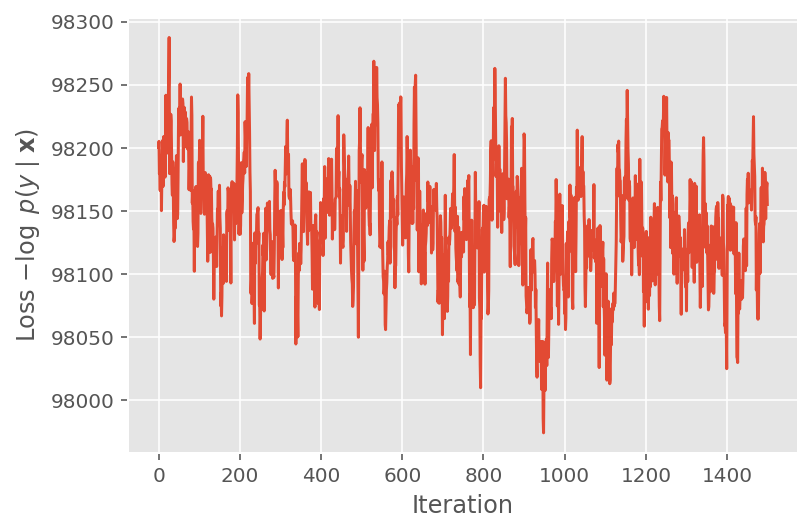

In [ ]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

また、特定の潜在的な次元にわたるマルコフ連鎖モンテカルロアルゴリズムの軌跡を示すトレースプロットも使用します。以下では、特定の講師の効果が実際に初期状態から有意義に移行し、状態空間を探索していることがわかります。トレースプロットは、効果が講師の間で異なるが、混合動作が類似していることも示しています。

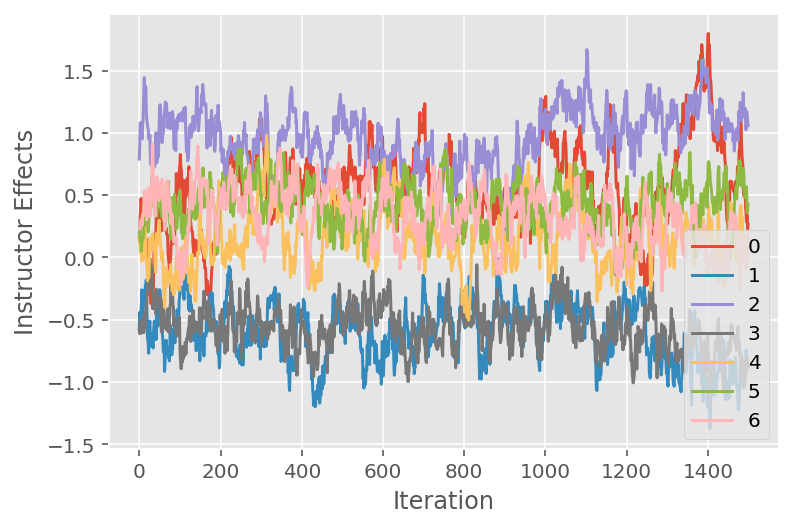

In [ ]:
for i in range(7):
  plt.plot(effect_instructors_samples[:, i])

plt.legend([i for i in range(7)], loc='lower right')
plt.ylabel('Instructor Effects')
plt.xlabel('Iteration')
plt.show()

## 批判

上記では、モデルを適合しました。ここでは、データを使用してその適合性を評価していきます。これにより、モデルを調査し、よりよく理解することができます。そのような手法の 1 つは、各データポイントのモデルの予測値と実測値の差をプロットする残差プロットです。モデルが正しければ、それらの差は標準正規分布になります。プロットがこのパターンから逸脱する場合は、モデルが適合していないことを示します。

まず、評価に対する事後予測分布を形成することにより残差プロットを作成します。これにより、変量効果の事前分布が、与えられた事後トレーニングデータに置き換えられます。特に、モデルを前方に実行し、推定された事後平均を使用して、事前変量効果への依存を除去します。²

In [ ]:
lmm_test = lmm_jointdist(features_test)

[
    effect_students_mean,
    effect_instructors_mean,
    effect_departments_mean,
] = [
     np.mean(x, axis=0).astype(np.float32) for x in [
       effect_students_samples,
       effect_instructors_samples,
       effect_departments_samples
       ]
]

# Get the posterior predictive distribution
(*posterior_conditionals, ratings_posterior), _ = lmm_test.sample_distributions(
    value=(
        effect_students_mean,
        effect_instructors_mean,
        effect_departments_mean,
))

ratings_prediction = ratings_posterior.mean()

視覚的な検査では、残差はある程度標準的で正規分布しているように見えます。ただし、近似は完全ではありません。正規分布よりも裾の確率質量が大きいため、モデルが正規性の仮定を緩和することで近似を改善する可能性があります。

特に、`InstEval` データセットの評価をモデル化するために正規分布を使用するのが最も一般的ですが、データを詳しく見ると、コースの評価は実際には 1 から 5 の順序値であることがわかります。これは、順序分布を使用する必要があること、または相対的な順序を破棄するのに十分なデータがある場合はカテゴリカルを使用する必要があることを示しています。これは、上記のモデルを 1 行変更するだけで、同一の推論コードを適用します。

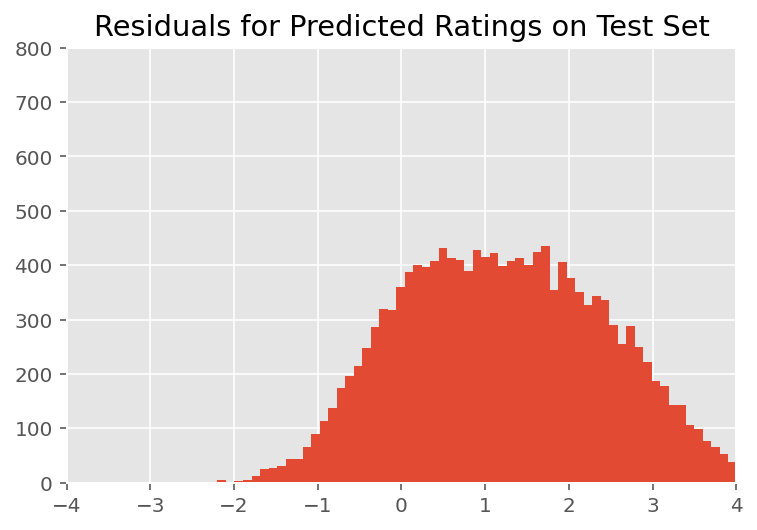

In [ ]:
plt.title("Residuals for Predicted Ratings on Test Set")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(ratings_prediction - labels_test, 75)
plt.show()

モデルがどのように個々の予測を行うかを調べるために、学生、講師、および学部の効果のヒストグラムを調べます。これにより、データポイントの特徴ベクトルの個々の要素が結果にどのように影響するかを理解できます。

当然のことながら、以下では、各学生が通常、講師の評価にほとんど影響を与えないことがわかります。また、興味深いことに、講師が所属する学部が大きな影響を及ぼしていることがわかります。

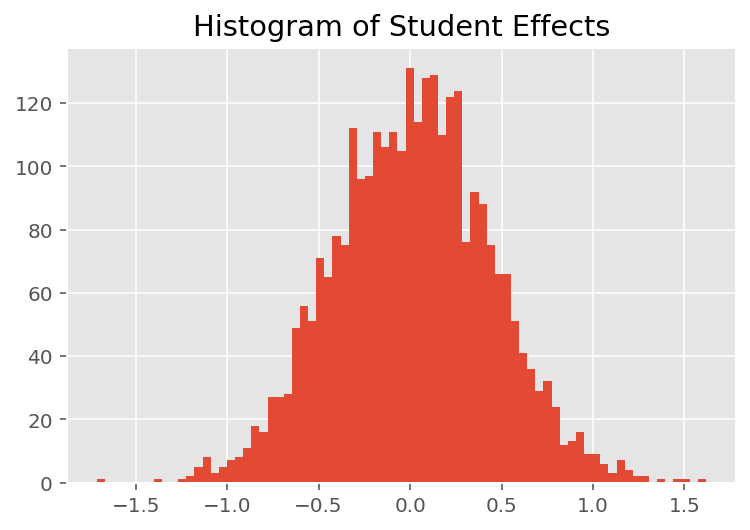

In [ ]:
plt.title("Histogram of Student Effects")
plt.hist(effect_students_mean, 75)
plt.show()

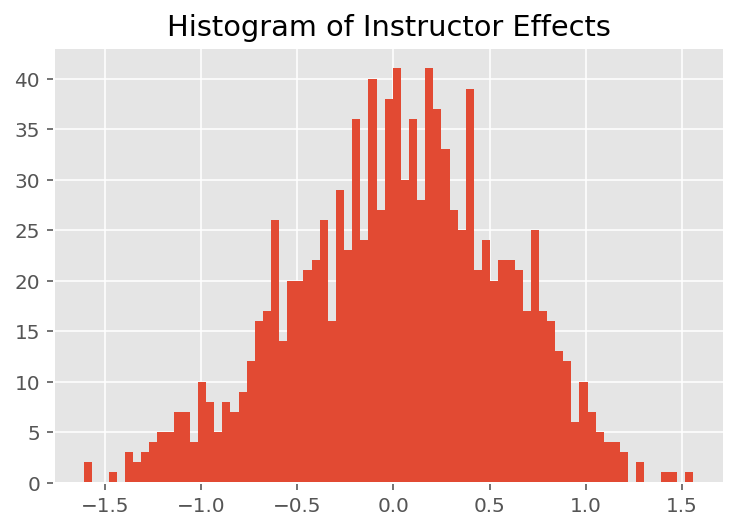

In [ ]:
plt.title("Histogram of Instructor Effects")
plt.hist(effect_instructors_mean, 75)
plt.show()

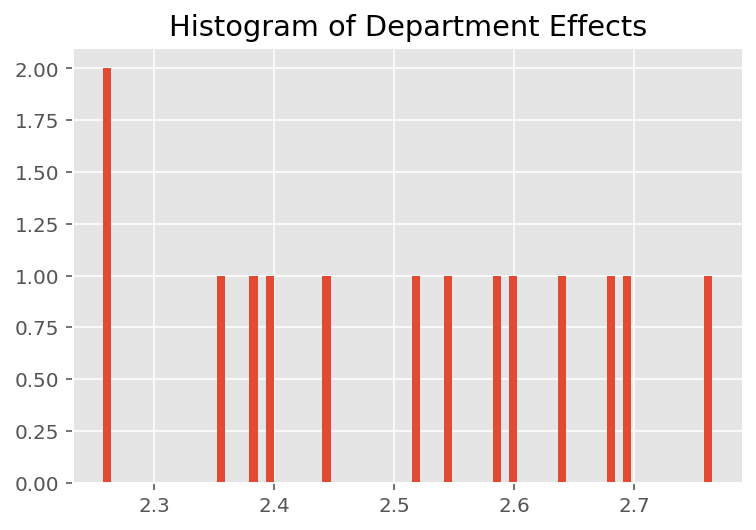

In [ ]:
plt.title("Histogram of Department Effects")
plt.hist(effect_departments_mean, 75)
plt.show()

## 脚注

¹ 線形混合効果モデルは、その周辺確率密度を分析的に計算できる特殊なケースです。このチュートリアルでは、モンテカルロ EM を示します。これは、尤度が正規ではなくカテゴリカルに拡張された場合など、非分析的周辺確率密度に簡単に適用できます。

² 簡単にするために、モデルの 1 つのフォワードパスのみを使用して予測分布の平均を作成します。これは事後平均の条件付けによって行われ、線形混合効果モデルに有効です。ただし、これは一般的には有効ではありません。事後予測分布の平均は通常、扱いにくく、事後サンプルが与えられたモデルの複数のフォワードパスにわたって経験的平均を取る必要があります。

## 謝辞

このチュートリアルは Edward 1.0  ([出典](https://github.com/blei-lab/edward/blob/master/notebooks/linear_mixed_effects_models.ipynb)) に掲載されたものです。そのバージョンの作成と改訂に貢献されたすべての人に感謝します。

## 参照文献

1. Douglas Bates and Martin Machler and Ben Bolker and Steve Walker. Fitting Linear Mixed-Effects Models Using lme4. *Journal of Statistical Software*, 67(1):1-48, 2015.

2. Arthur P. Dempster, Nan M. Laird, and Donald B. Rubin. Maximum likelihood from incomplete data via the EM algorithm. *Journal of the Royal Statistical Society, Series B (Methodological)*, 1-38, 1977.

3. Andrew Gelman and Jennifer Hill. *Data analysis using regression and multilevel/hierarchical models.* Cambridge University Press, 2006.

4. David A. Harville. Maximum likelihood approaches to variance component estimation and to related problems. *Journal of the American Statistical Association*, 72(358):320-338, 1977.

5. Michael I. Jordan. An Introduction to Graphical Models. Technical Report, 2003.

6. Nan M. Laird and James Ware. Random-effects models for longitudinal data. *Biometrics*, 963-974, 1982.

7. Greg Wei and Martin A. Tanner. A Monte Carlo implementation of the EM algorithm and the poor man's data augmentation algorithms. *Journal of the American Statistical Association*, 699-704, 1990.